I put togehter an example jupyter notebook to illustrate how the code works. Just for the record, I of course did not run everything on a laptop in a notebook like this.

In [2]:
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import DataLoader
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pennylane as pl

device = 'cpu' # Cuda support for PennyLane is possible though

In [3]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.quantum_models as qm

Pick a data set out of the next three cells.

In [4]:
# this cell details how the synthetic dataset is generated

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

n_samples = 500
n_features = 3
n_informative = 3
n_targets = 1
noise = 1.0
random_state = 42
X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_targets=n_targets, noise=noise, random_state=random_state)
X, y = torch.from_numpy(X), torch.from_numpy(y)

In [ ]:
# generate a random PQC regression problem
n_samples = 3500
n_dim = 4
n_layers = 2
n_trainable_block_layers = 2
target_model = qm.QuantumRegressionModel(n_dim, n_layers=n_layers, n_trainable_block_layers=n_trainable_block_layers)
rng = np.random.default_rng()
X = torch.from_numpy(rng.random((n_samples, n_dim)))

with torch.no_grad():
    y = target_model(X).flatten()

In [ ]:
# load california housing dataset
data = fetch_california_housing()
X = torch.from_numpy(data.data)
y = torch.from_numpy(data.target)

In [ ]:
# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# torch dataloaders
train_data_list = []
for i in range(len(X_train)):
    data_point = (X_train[i], y_train[i])
    train_data_list.append(data_point)

test_data_list = []
for i in range(len(X_test)):
    data_point = (X_test[i], y_test[i])
    test_data_list.append(data_point)
    
train_dataloader = DataLoader(train_data_list, batch_size=500, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=500, shuffle=True)

In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.flatten(), y)
            loss.backward()
            return loss
        
        optimizer.step(closure)

        if batch % 100 == 0:
            loss = loss_fn(model(X).flatten(), y)
            loss, current = loss.item(), batch * len(X)

        return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

# The Quantum Model

In [41]:
n_qubits = n_features
model = qm.QuantumRegressionModel(n_qubits, n_layers=2, n_trainable_block_layers=1)
model.to(device)
loss_fn = nn.MSELoss(reduction='mean') 
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.5, line_search_fn="strong_wolfe")

In [42]:
# Training
NN_loss = []
NN_test_loss = []

NN_loss.append(test(train_dataloader, model, loss_fn))
NN_test_loss.append(test(test_dataloader, model, loss_fn)) 
epochs = 50
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    NN_loss.append(test(train_dataloader, model, loss_fn))
    NN_test_loss.append(test(test_dataloader, model, loss_fn))    
    print("Done!")

Test Error: 
 Accuracy: 0.0%, Avg loss: 10445.748672 

Test Error: 
 Accuracy: 0.0%, Avg loss: 9274.028752 



  0%|                                                    | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 6484.783754 



  2%|▊                                        | 1/50 [03:01<2:27:58, 181.20s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 5465.040479 

Done!
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1404.798334 



  4%|█▋                                       | 2/50 [05:46<2:17:31, 171.90s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 818.848552 

Done!
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 392.590092 



  6%|██▍                                      | 3/50 [08:18<2:07:34, 162.86s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 201.681017 

Done!
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 280.514933 



  8%|███▎                                     | 4/50 [11:00<2:04:27, 162.34s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 178.793668 

Done!
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 209.354704 



 10%|████                                     | 5/50 [13:57<2:05:44, 167.66s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 81.927583 

Done!
Epoch 6
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 139.421382 



 12%|████▉                                    | 6/50 [16:34<2:00:23, 164.17s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 69.263699 

Done!
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 78.469631 



 14%|█████▋                                   | 7/50 [19:39<2:02:23, 170.79s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 82.509632 

Done!
Epoch 8
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 52.523965 



 16%|██████▌                                  | 8/50 [22:53<2:04:46, 178.24s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 50.112167 

Done!
Epoch 9
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 45.026523 



 18%|███████▍                                 | 9/50 [25:30<1:57:17, 171.65s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 41.011686 

Done!
Epoch 10
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 39.926677 



 20%|████████                                | 10/50 [28:21<1:54:21, 171.54s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 42.740865 

Done!
Epoch 11
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 35.606628 



 22%|████████▊                               | 11/50 [30:56<1:48:09, 166.41s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 30.609509 

Done!
Epoch 12
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 30.697256 



 24%|█████████▌                              | 12/50 [33:52<1:47:12, 169.27s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 32.724976 

Done!
Epoch 13
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 28.613701 



 26%|██████████▍                             | 13/50 [36:28<1:41:52, 165.21s/it]

Test Error: 
 Accuracy: 0.0%, Avg loss: 35.095889 

Done!
Epoch 14
-------------------------------


 26%|██████████▍                             | 13/50 [37:02<1:45:26, 170.98s/it]


KeyboardInterrupt: 

In [ ]:
x = np.arange(0, len(NN_loss), 1)
plt.plot(x, NN_loss, label="training loss")
plt.plot(x, NN_test_loss, label="test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

# The Classical Surrogate

In [6]:
# generate frequencies
max_freq = 2
dim = X_scaled[0].shape[0]

W = utils.freq_generator(max_freq, dim, mode="half")

In [7]:
# defining and training the model
NN_loss = []
NN_test_loss = []
W.to(device)
model = fm.Fourier_model(W)
model.to(device)
loss_fn = nn.MSELoss(reduction='mean') 
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.5, history_size=50, line_search_fn="strong_wolfe")

epochs = 50
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    NN_loss.append(test(train_dataloader, model, loss_fn))
    NN_test_loss.append(test(test_dataloader, model, loss_fn))    
    print("Done!")

  6%|██▋                                         | 3/50 [00:00<00:02, 23.39it/s]

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 45.163286 

Test Error: 
 Accuracy: 0.0%, Avg loss: 83.601879 

Done!
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 14.404836 

Test Error: 
 Accuracy: 0.0%, Avg loss: 35.180218 

Done!
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 8.924340 

Test Error: 
 Accuracy: 0.0%, Avg loss: 23.806984 

Done!
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 4.330860 

Test Error: 
 Accuracy: 0.0%, Avg loss: 6.796065 

Done!
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 2.726331 

Test Error: 
 Accuracy: 0.0%, Avg loss: 4.939175 

Done!
Epoch 6
-------------------------------


 18%|███████▉                                    | 9/50 [00:00<00:01, 27.25it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.799025 

Test Error: 
 Accuracy: 0.0%, Avg loss: 5.636310 

Done!
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.604898 

Test Error: 
 Accuracy: 0.0%, Avg loss: 4.492684 

Done!
Epoch 8
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.527560 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.637062 

Done!
Epoch 9
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.458165 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.875007 

Done!
Epoch 10
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.396421 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.692347 

Done!
Epoch 11
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.349473 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.635946 

Done!
Epoch 12
-------------------------------


 30%|████████████▉                              | 15/50 [00:00<00:01, 27.66it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.295402 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.719406 

Done!
Epoch 13
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.248005 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.747068 

Done!
Epoch 14
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.220160 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.759839 

Done!
Epoch 15
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.190572 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.128378 

Done!
Epoch 16
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.170162 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.083592 

Done!
Epoch 17
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.156331 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.146102 

Done!
Epoch 18
-------------------------------


 42%|██████████████████                         | 21/50 [00:00<00:01, 27.19it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.143110 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.355193 

Done!
Epoch 19
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.135633 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.157237 

Done!
Epoch 20
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.125938 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.983465 

Done!
Epoch 21
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.112436 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.962742 

Done!
Epoch 22
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.094351 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.061556 

Done!
Epoch 23
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.082696 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.888263 

Done!
Epoch 24
-------------------------------


 58%|████████████████████████▉                  | 29/50 [00:01<00:00, 29.84it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.075394 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.719285 

Done!
Epoch 25
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.067515 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.558624 

Done!
Epoch 26
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.061822 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.564793 

Done!
Epoch 27
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.051930 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.454781 

Done!
Epoch 28
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.044554 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.529288 

Done!
Epoch 29
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.036663 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.569705 

Done!
Epoch 30
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.032695 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.732974 

Done

 70%|██████████████████████████████             | 35/50 [00:01<00:00, 27.28it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.025702 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.050903 

Done!
Epoch 32
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.018982 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.081396 

Done!
Epoch 33
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.010293 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.383030 

Done!
Epoch 34
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.003948 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.436955 

Done!
Epoch 35
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.999284 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.459621 

Done!
Epoch 36
-------------------------------


 84%|████████████████████████████████████       | 42/50 [00:01<00:00, 29.22it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.996458 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.390968 

Done!
Epoch 37
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.992371 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.404602 

Done!
Epoch 38
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.986300 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.330491 

Done!
Epoch 39
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.984471 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.315313 

Done!
Epoch 40
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.982342 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.407478 

Done!
Epoch 41
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.979353 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.457722 

Done!
Epoch 42
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.977418 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.488594 

Done

 92%|███████████████████████████████████████▌   | 46/50 [00:01<00:00, 29.75it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.975875 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.526814 

Done!
Epoch 44
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.972773 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.514214 

Done!
Epoch 45
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.968406 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.596529 

Done!
Epoch 46
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.964635 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.603965 

Done!
Epoch 47
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.961738 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.674281 

Done!
Epoch 48
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.959620 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.742173 

Done!
Epoch 49
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.957795 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.728905 

Done

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 28.52it/s]

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.956061 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3.685173 

Done!


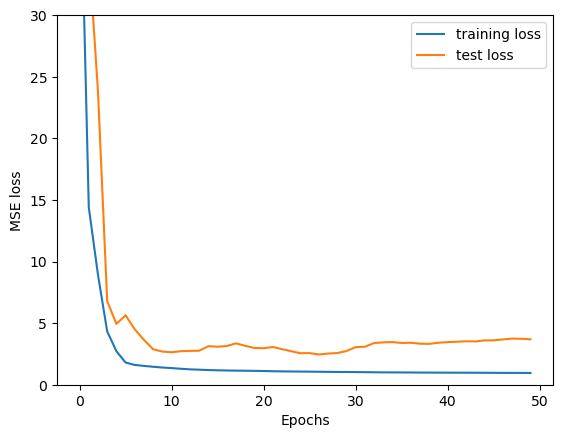

In [9]:
x = np.arange(0, len(NN_loss), 1)
plt.plot(x, NN_loss, color="C0", label="training loss")
plt.plot(x, NN_test_loss, color="C1", label="test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.ylim(0,30)
plt.legend()